In [46]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

### A/B Testing Case Study
Here we are evaluating the impact of UX changes on a mock e-commerce webpage, spliting users into control and experimental groups, and we are checking if there any statistical and practical significance difference between the CTR of the two versions of the web page because a higher CTR means higher engagement and hence better business.

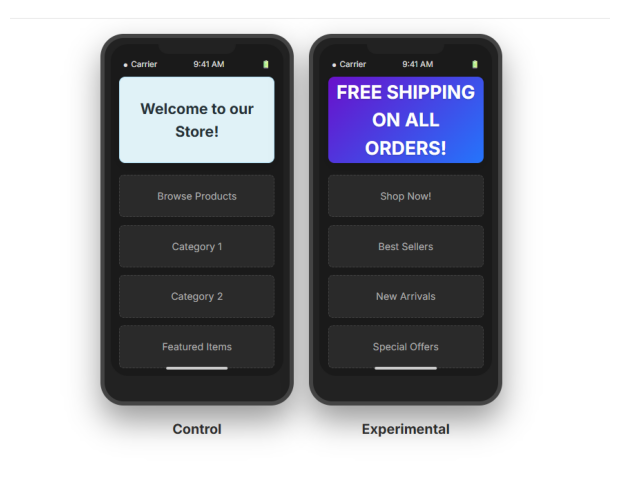

In [47]:
image = Image.open('ab_results.png')
fig = plt.figure(figsize=(6,5))
ax = fig.add_axes([0,0,1,1])
ax.imshow(image)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### Simulated Datase
Here we are simulating a dataset with a total of 20k user responses, with each experimental and control version having 10k responses, here we are assuming that the CTR in case of control group is 20% and in case of experimental group CTR is 40%. And we need to check if this difference between the CTR of control and experimental group is statistically and practically significant.

In [48]:
def simulate_ctr_ab_test(n_users=20000, p_control=0.20, p_experiment=0.40, seed=42):
    """
    Simulate an A/B test dataset for click-through rate (CTR) analysis with:
    - Control group CTR = 20%
    - Experimental group CTR = 40%
    """
    np.random.seed(seed)
    
    # Create user IDs and assign groups evenly
    user_ids = np.arange(1, n_users + 1)
    groups = np.array(['con'] * (n_users // 2) + ['exp'] * (n_users // 2))
    np.random.shuffle(groups)
    
    # Simulate clicks for control and experimental groups
    clicks = np.where(
        groups == 'con',
        np.random.binomial(1, p_control, size=n_users),
        np.random.binomial(1, p_experiment, size=n_users)
    )
    # Build DataFrame
    df = pd.DataFrame({
        'user_id': user_ids,
        'group': groups,
        'click': clicks
    })
    return df

# Generate and preview the updated dataset
df = simulate_ctr_ab_test()


In [49]:
df.head(5)

,user_id,group,click
0,1,exp,1
1,2,con,0
2,3,con,0
3,4,con,0
4,5,exp,0


In [50]:
df.shape

(20000, 3)

### Hypothesis
First we need to state the Null & Alternative Hypothesis, here p is the proportion of the clicks and the total number of visits,null hypothesis states there is no statisitcal significant difference between these two versions of the web page while the alternative hypothesis is exactly opposite of the null hypothesis.

<span style="font-size: 20px;">
$$
\begin{aligned}
H_0:&\quad p_{\mathrm{exp}} = p_{\mathrm{con}} \\
H_1:&\quad p_{\mathrm{exp}} \neq p_{\mathrm{con}}
\end{aligned}
$$


### Power Analysis

In [51]:
beta = 0.2   # probablity of Type II error
power = 1 - beta
alpha = 0.05 # probablity of Type I error
mde = 0.1 # minimum detectable effect( it is the minimum difference we want to detect between two groups
p_control = 0.20   # baseline click through rate
p_experimental = p_control + mde  # we want to detect mde
ratio = 1.0   # n_exp/n_con

# Compute Cohen's h effect size for two proportions
effect_size = proportion_effectsize(p_experimental, p_control)

# for sample size per group
analysis = NormalIndPower()
n_per_group = analysis.solve_power(
    effect_size=effect_size, power=power,
    alpha=alpha,ratio=ratio,alternative='two-sided')

print(f"Required sample size per group for a proper a/b test without p-hacking: {n_per_group:.0f}")
print(f"Total samples needed to be collected: {2 * n_per_group:.0f}")

Required sample size per group for a proper a/b test without p-hacking: 292
Total samples needed to be collected: 583


As we can see the minimum sample size we should use in order to conduct a proper a/b test and avoid p-hacking 
is **292** and we have already collected **10k** samples per group in the simulated dataset, so our a/b test will be conducted properly without any p-hacking.

### Data Visulaization

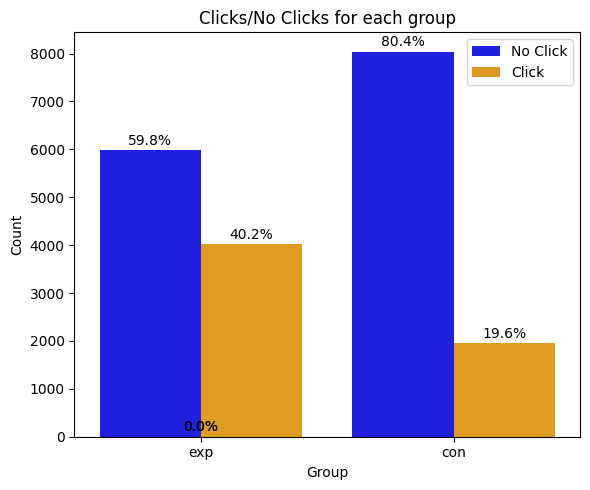

In [52]:
palette = {1:'orange',0:'blue'}
labels = ['No Click','Click']
plt.figure(figsize=(6,5))
ax = sns.countplot(x='group',hue='click',data=df,palette=palette,hue_order=[0,1])
ax.set_xlabel('Group')
ax.set_ylabel('Count')
ax.set_title('Clicks/No Clicks for each group')
ax.legend(labels=['No Click', 'Click'])

n_per_group = 10000
for p in ax.patches:
    count = p.get_height()
    pct = count / n_per_group * 100
    # x-coordinate of the center of the bar
    x = p.get_x() + p.get_width() / 2
    ax.text(
        x, count + 50,               
        f'{pct:.1f}%',                
        ha='center', va='bottom'
    )
plt.tight_layout()
plt.show()

### A/B Test Result Analysis

In [53]:
# grouping the data by the group
grouped = df.groupby('group')

# total number of control and experimental users
N_con = grouped['click'].count().loc['con']
N_exp = grouped['click'].count().loc['exp']

# proportion of control and experimental people who clicked 
n_con = grouped['click'].sum().loc['con']  # users who clicked in control group
n_exp = grouped['click'].sum().loc['exp']  # users who clciked in exp group
p_con = n_con/N_con
p_exp = n_exp/N_con

# calculating pooled proportion( total clicks over total responses)
p_pooled = (n_con + n_exp)/(N_con + N_exp)

# calculating pooled variannce for calculating the Standard error
pooled_var = p_pooled * (1 - p_pooled) * (1/N_exp + 1/N_con)

# calculating the standard error which is just sqrt of pooled variance
SE = np.sqrt(pooled_var)

#### Statistical Test
Here we are using a **two proportion z-test**, as we have a sample size greater than 30 hence the distribution follows a normal distribution with minimum certainity so we can use both z-test and t-test for this situation.

In [54]:
# calculating the z_critical value for 95% confidence interval(alpha=0.05)
z_critical = norm.ppf(1 - alpha/2)   # two tailed
print(f'z_critical is {z_critical}')

# calculating the test statistics(z-statistic)
z_stat = (p_exp - p_con)/SE
print(f'z-statistic is {z_stat}')

# calculating the two-sided p-value as we are performing a two-sided test
p_value = 2 * (1 - norm.cdf(abs(z_stat)))
print(f'p-value is {p_value}')


z_critical is 1.959963984540054
z-statistic is 31.80906874214723
p-value is 0.0


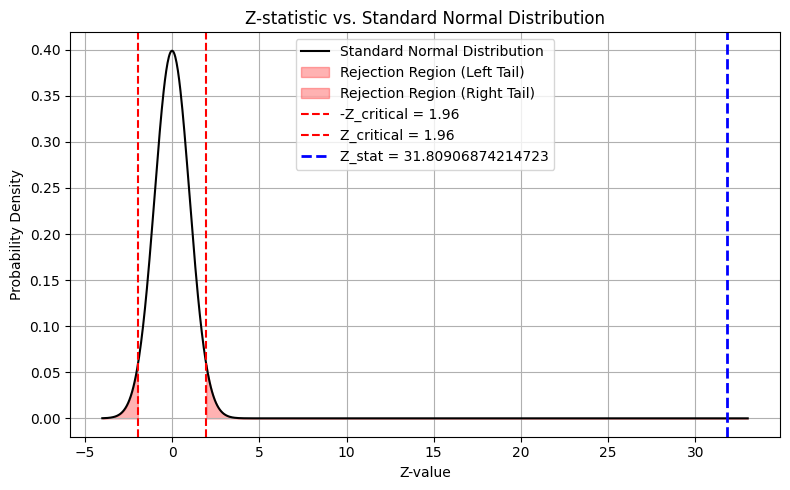

In [60]:
# density plot for the distibution showcasing how far our statistic is from the critical value
z_values = np.linspace(-4, 33, 1000)
pdf_values = norm.pdf(z_values)

# Plot the standard normal distribution
plt.figure(figsize=(8, 5))
plt.plot(z_values, pdf_values, label='Standard Normal Distribution', color='black')

# Fill the critical regions (both tails)
plt.fill_between(z_values, pdf_values, where=(z_values <= -z_critical), color='red', alpha=0.3, label='Rejection Region (Left Tail)')
plt.fill_between(z_values, pdf_values, where=(z_values >= z_critical), color='red', alpha=0.3, label='Rejection Region (Right Tail)')

# Plot z-critical values
plt.axvline(-z_critical, color='red', linestyle='--', label=f'-Z_critical = {z_critical:.2f}')
plt.axvline(z_critical, color='red', linestyle='--', label=f'Z_critical = {z_critical:.2f}')

# Plot the z-statistic
plt.axvline(z_stat, color='blue', linestyle='--', linewidth=2, label=f'Z_stat = {z_stat}')

# Labels and legend
plt.title('Z-statistic vs. Standard Normal Distribution')
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Statistical Signifiance
Our null hypothesis states that there is no differnce between the CTR of the two versions, so for testing this hypothesis we performed two-sided two-sample z-test and calculated the p-value, here if the p-value if lower than the significance level(alpha) then we can reject the null hypothesis and accept the alternative hypothesis means there is a statically siginficant differnce between the CTR of the control and experimental version of the web page.

Here we are running a two sided test which detects a differnce in both directions but as we know from the graph the p_exp is higher than the p_con hence the differnce is indicating the improvement of CTR in the experimental group.

In [56]:
# function for checking either the changes are statisically significant or not
def is_statistically_significant(p_value = p_value,alpha = alpha):
    """
    alpha: Significance level(probablity of Type-1 error)
    p-value: probablity of equally or more rare events
    """
    if p_value <= alpha:
        print('We can reject the null hypothesis hence there is a statisically significant differnce')
    else:
        print('We fail to reject the null hypothesis hence there is no statically siginificant differnce')

is_statistically_significant()

We can reject the null hypothesis hence there is a statisically significant differnce


### Confidence Interval
Along with statistical significance we also need to estimate the practical significance of the changes for implementing the changes in real life and be sure that we will achieve a certain improvement. For this we need to calculate the confidence interval, here we are using a **95% confidence interval** for checking practical significance.

Also the thickness of Confidence interval helps us to determine how well our test is conducted , if the CI is very thin it means the test accuracy is pretty high.

In [57]:
# calculating the 95% confidence interval
CI = (0,0)
lower_bound = (p_exp - p_con) - (z_critical * SE)
upper_bound = (p_exp - p_con) + (z_critical * SE)
CI = round(lower_bound,2),round(upper_bound,2)
print(f'95% Confidence Interval is {CI}')

95% Confidence Interval is (0.19, 0.22)


### Practical Significance
If the minimum detectable effect(MDE) which is the minimum improvement we want to detect is lower than the lower bound of CI , then we can state there is practically significant differnce between two versions, as even the lowest possible diffrence or improvement is higher than the MDE.

In [58]:
# function for checking either the changes are practically significant or not
def is_practically_significant(CI = CI,mde = mde):
    """
    CI: 95% confidence interval
    mde: minimum detectable effect
    """
    if mde <= CI[0]:
        print('There is a practically significant differnce betwen the CTR of two versions')
    else:
        print('There is no practically significant differnce between the CTR of two versions')

is_practically_significant()
        

There is a practically significant differnce betwen the CTR of two versions


### Conclusion
Here our main goal for this A/B test was to determine if there is a statiscally and practically significant improvement or difference between the experimental and control version of the e-commerce web page, after analyzing the results of the A/B test we have found there is a statically and practically siginficant improvement in the CTR of experimental version, hence we can make these changes to our final product to achieve better engagement and business.